# ASSIGNMENT 3 - DEEP RL

## PART 1

### IMPORTING LIBRARIES

In [4]:
import os
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.common.wrappers import ActionMasker
import matplotlib.pyplot as plt

from knapsack_env import BoundedKnapsackEnv
from stable_baselines3.common.env_util import make_vec_env



import numpy as np
import gymnasium as gym
import torch as th

seed = 2020
np.random.seed(seed)

In [5]:
def plot_results(log_folder, title="Learning Curve"):
    """
    Plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")

    # Plot average reward vs timesteps
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title("Average reward vs timesteps")

    # Find the timestep with the highest reward
    max_reward_idx = np.argmax(y)
    max_reward_timestep = x[max_reward_idx]
    max_reward_value = y[max_reward_idx]

    # Plot vertical line at the highest reward timestep
    plt.axvline(x=max_reward_timestep, color='r', linestyle='--', label=f'Highest Reward ({max_reward_value:.2f})')
    plt.legend()
    plt.show()

    # Plot average accumulated reward over timesteps
    plt.plot(x, np.cumsum(y))
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title("Average accumulated reward over timesteps")

    # Plot vertical line at the highest reward timestep
    plt.axvline(x=max_reward_timestep, color='r', linestyle='--', label=f'Highest Reward ({max_reward_value:.2f})')
    plt.legend()
    plt.show()

    print(f"Timestep with highest reward: {max_reward_timestep}")
    print(f"Highest reward achieved: {max_reward_value}")

In [6]:
log_dir = os.getcwd()+r'\DQN'

def make_env():
    os.makedirs(log_dir, exist_ok=True)

    env = BoundedKnapsackEnv(n_items=200, max_weight=200)
    env = Monitor(env, log_dir)


    # Wrapping up the environment on mask function
    return env

In [7]:
# Create log dir
# Change the path if required

# Wrap the environment with DummyVecEnv
env = make_vec_env(make_env, n_envs=1)

# Normalize the observations and rewards
env = VecNormalize(env, norm_obs=True, norm_reward= True, clip_obs= float('inf'))

In [8]:
env.observation_space

Box(0, 200, (3, 201), int32)

In [14]:
# Define Total time steps
total_timesteps = 25000

callback = EvalCallback(env, best_model_save_path="DQN/best_model",
                             log_path="./DQN/logs/results", eval_freq=2000, render=False)


policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=[128, 128])
model_1 = DQN("MlpPolicy", env, learning_rate=0.0001, gamma=0, exploration_fraction= 0.1, policy_kwargs=policy_kwargs, batch_size = 32, verbose=1, tensorboard_log="./ppo_knapsack_tensorboard/")
model_1.learn(total_timesteps= total_timesteps, log_interval=50, callback = callback)


Using cpu device
Logging to ./ppo_knapsack_tensorboard/DQN_40


c:\Anacondainstalledhere\envs\Ai\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 4.84GB > 0.72GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.42     |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 664      |
|    time_elapsed     | 0        |
|    total_timesteps  | 271      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 42       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.31     |
|    ep_rew_mean      | 219      |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 533      |
|    time_elapsed     | 0        |
|    total_timesteps  | 531      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.144    |
|    n_updates      

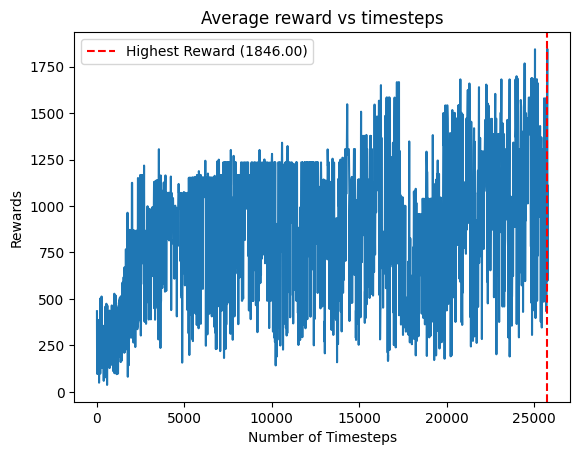

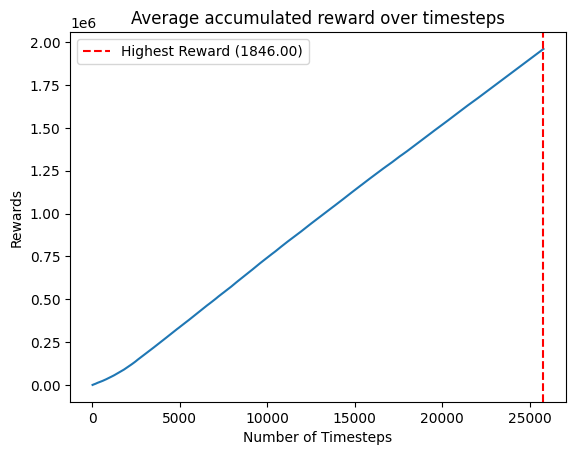

Timestep with highest reward: 25751
Highest reward achieved: 1846.0


In [17]:
plot_results(log_dir)

In [ ]:
env.training = False 
env.norm_reward = False     # Setting env to unnormalized state

# Load best model
#model_1 = DQN.load("DQN/best_model/best_model.zip", env=env)   
mean_reward, std_reward = evaluate_policy(model_1, env, n_eval_episodes=100, deterministic= True)
print(f"Mean reward: {mean_reward} ± {std_reward}")

Mean reward: 1593.0 ± 0.0


### PPO

In [9]:
# Create log dir
# Change the path if required
log_dir = os.getcwd()+r'\PPO'
os.makedirs(log_dir, exist_ok=True)

env = BoundedKnapsackEnv(n_items=200, max_weight=200)
env = Monitor(env, log_dir)

env = make_vec_env(make_env, n_envs=1)
env = VecNormalize(env, norm_obs=True, norm_reward= True, clip_obs= float('inf'))

In [12]:
# Define Total time steps
total_timesteps = 25000

In [14]:
env.training = True # Setting env to normalized state
env.norm_reward = True

callback = EvalCallback(env, best_model_save_path="PPO/best_model",
                             log_path="./PPO/logs/results", eval_freq=2000, render=False)

policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[128, 128], vf=[128, 128]))

model_2 = PPO("MlpPolicy", env, n_epochs = 10, learning_rate=0.001, batch_size = 32, gamma = 0.99, policy_kwargs= policy_kwargs, ent_coef=0.0, verbose=1, tensorboard_log="./ppo_knapsack_tensorboard/")
model_2.learn(total_timesteps= total_timesteps, callback = callback)

Using cpu device
Logging to ./ppo_knapsack_tensorboard/PPO_2
Eval num_timesteps=2000, episode_reward=459.00 +/- 0.00
Episode length: 7.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 7        |
|    mean_reward     | 459      |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.38     |
|    ep_rew_mean     | 158      |
| time/              |          |
|    fps             | 568      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=4000, episode_reward=227.00 +/- 0.00
Episode length: 4.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 4          |
|    mean_reward          | 227        |
| t

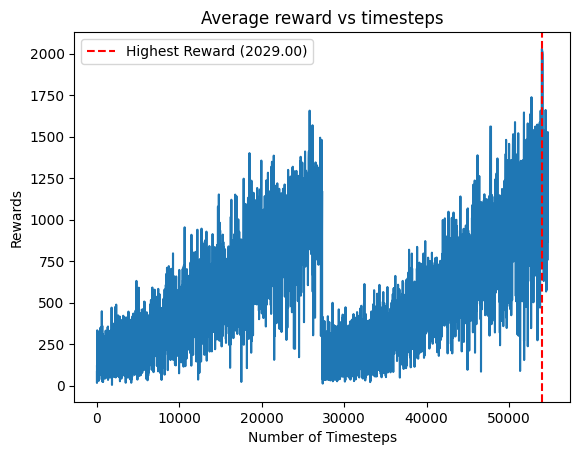

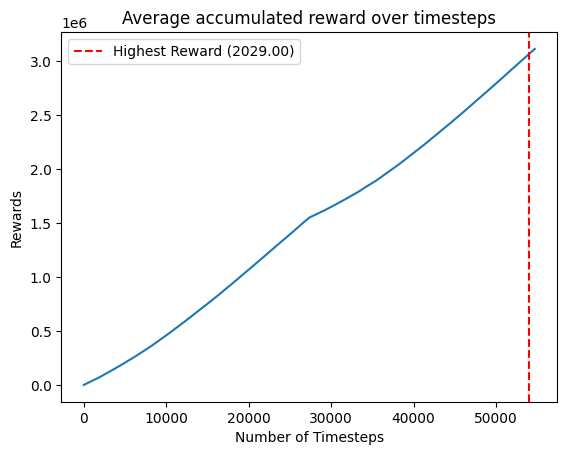

Timestep with highest reward: 53971
Highest reward achieved: 2029.0


In [15]:
plot_results(log_dir)

In [12]:
env.training = False 
env.norm_reward = False     # Setting env to unnormalized state

# Load best model
model_2 = PPO.load("PPO/best_model/best_model.zip", env=env)
mean_reward, std_reward = evaluate_policy(model_2, env, n_eval_episodes=100, deterministic= True)
print(f"Mean reward: {mean_reward} ± {std_reward}")

Mean reward: 1679.0 ± 0.0
